In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from scipy.fft import fft2
from scipy.ndimage import sobel
import matplotlib.pyplot as plt

import os


In [2]:

folder = r'/Users/Leon/Documents/Data GH/Vision Computación/Texturas/Brodatz_examples'
valid_exts = ('.png', '.jpg', '.jpeg', '.bmp') 
image_paths = [os.path.join(folder, fname) for fname in os.listdir(folder) if fname.lower().endswith(valid_exts)][:20]  



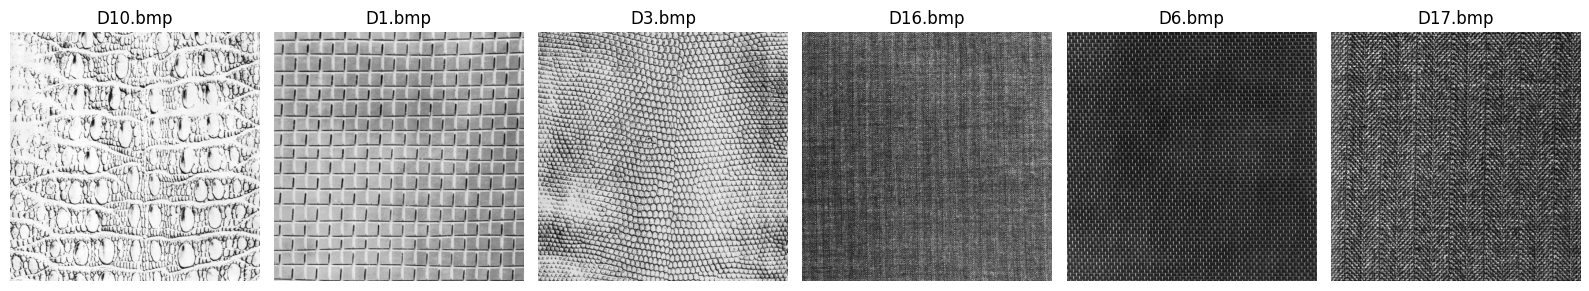

In [3]:
import matplotlib.pyplot as plt
import os

images = [cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) for img_path in image_paths]

fig, axes = plt.subplots(1, 6, figsize=(16, 6))  
for ax, img, name in zip(axes, images, image_paths):
    ax.imshow(img, cmap='gray')  
    ax.set_title(os.path.basename(name))  
    ax.axis('off')  

plt.tight_layout() 
plt.show()

In [4]:

def load_images(image_paths):
    images = []
    names = []
    for path in image_paths:
        try:
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                print(f"Una de las imágenes es nula: {path}")
            else:
                name = os.path.basename(path)
                images.append(image) 
                names.append(name)  # Aquí también añadimos el nombre
        except Exception as e:
            print(f"Error al cargar la imagen '{path}': {e}") 
    return images, names

In [5]:
#Equalización de las imágenes
def equalize_image(img):
    #si estamos en escala de grises
    if len(img.shape)==2:
        return cv2.equalizeHist(img) 
    #si la imagen tiene tres canales
    elif len(img.shape)==3:
        eq_channels = []
        channels = cv2.split(img) #separamos los canales 
        for c in channels:
            ecualized = cv2.equalizeHist(c)
            eq_channels.append(ecualized) 
        return cv2.merge(eq_channels)
    else:
        print("Ecualizacion fallida, formato no esperado")

In [6]:
#Extracción de Caracteristicas GLCM
from skimage.feature import graycomatrix, graycoprops
import numpy as np

def feature_extraction(texel):

    # Asegúrate de que el texel sea uint8 (necesario para graycomatrix)
    texel = (texel * 255).astype(np.uint8) if texel.max() <= 1.0 else texel.astype(np.uint8)

    # Parámetros de GLCM
    distances = [1, 2, 4]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    # Calcular GLCM
    glcm = graycomatrix(texel, 
                        distances=distances,
                        angles=angles,
                        levels=256,
                        symmetric=True,
                        normed=True)

    # Propiedades a extraer
    props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']

    # Vector de características (valores individuales por dist × ángulo)
    features = []
    for prop in props:
        values = graycoprops(glcm, prop)  # shape: (len(dist), len(angles)) → (3, 4)
        features.extend(values.flatten())  # convertimos a vector (3×4 = 12 valores por propiedad)

    return features


In [7]:

# Frecuencia, escala y orientación
def extract_additional_features(image):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    f = np.abs(fft2(gray))
    freq_mean = np.mean(f)
    freq_std = np.std(f)
    grad_x = sobel(gray, axis=0)
    grad_y = sobel(gray, axis=1)
    orientation = np.arctan2(grad_y, grad_x)
    orientation_mean = np.mean(orientation)
    orientation_std = np.std(orientation)
    return [freq_mean, freq_std, orientation_mean, orientation_std]

In [8]:
# Vector completo
def build_feature_vector(image):
    image = equalize_image(image)
    features = []
    if len(image.shape) == 3:
        for i in range(3):
            features += feature_extraction(image[:, :, i])
    else:
        features += feature_extraction(image)
    features += extract_additional_features(image)
    return features

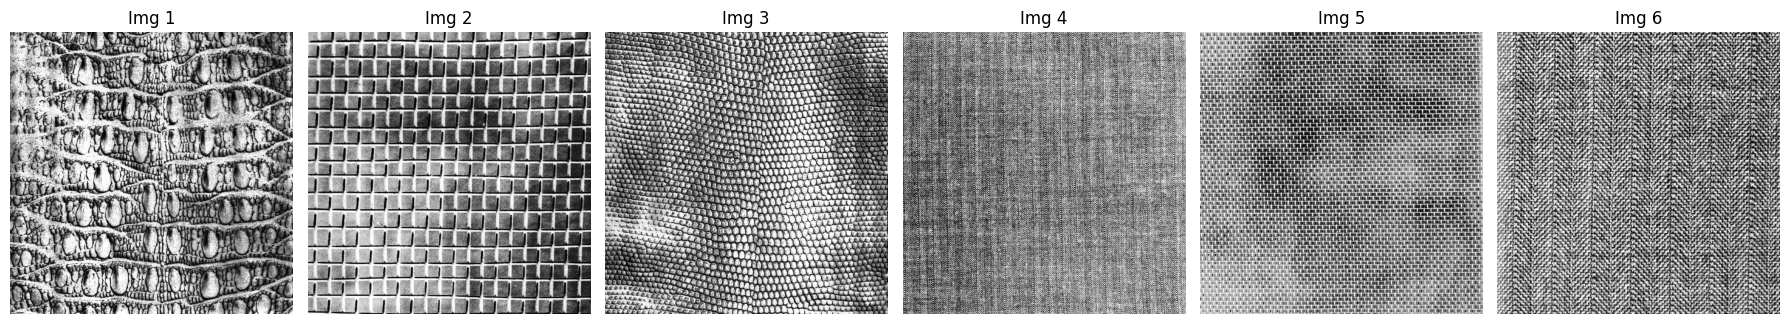

In [9]:
# Ecualizamos las imágenes
equalized_images = [equalize_image(img) for img in images]  


import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 6, figsize=(18, 4))  # 6 imágenes en una fila

for i, ax in enumerate(axes):
    ax.imshow(equalized_images[i], cmap='gray')
    ax.set_title(f'Img {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()



In [10]:
# dadas las distintas texturas, crearemos un vector donde indiquemos el tamño de textel para cada imagen
tamaños_por_imagen = [
    (128, 128),  # para imagen 0
    (128, 128),  # para imagen 1
    (64, 64),  # para imagen 2
    (32, 32),  # para imagen 3
    (64, 64),  # para imagen 4
    (128, 128) # para imagen 5
]


In [11]:
import random
from skimage.util import view_as_windows

# Listas para almacenar datos de todos los texeles
X_train, y_train = [], []
X_test, y_test = [], []

for idx, (imagen, tam_texel) in enumerate(zip(equalized_images, tamaños_por_imagen)):
    if imagen.ndim == 3:
        from skimage.color import rgb2gray
        imagen = rgb2gray(imagen)

    # Extraer texeles sin traslape
    texeles = view_as_windows(imagen, tam_texel, step=tam_texel[0])
    texeles = texeles.reshape(-1, *tam_texel)

    # Asegurar suficientes texeles
    if len(texeles) < 5:
        print(f"⚠️ Imagen {idx} tiene solo {len(texeles)} texeles, se omite.")
        continue

    # Separar por índice para evitar duplicados
    indices = list(range(len(texeles)))
    random.seed(42)
    random.shuffle(indices)
    test_idx = indices[:4]
    train_idx = indices[4:]

    for i in train_idx:
        X_train.append(texeles[i])
        y_train.append((idx, tam_texel))  # o idx si solo te importa la imagen

    for i in test_idx:
        X_test.append(texeles[i])
        y_test.append((idx, tam_texel))



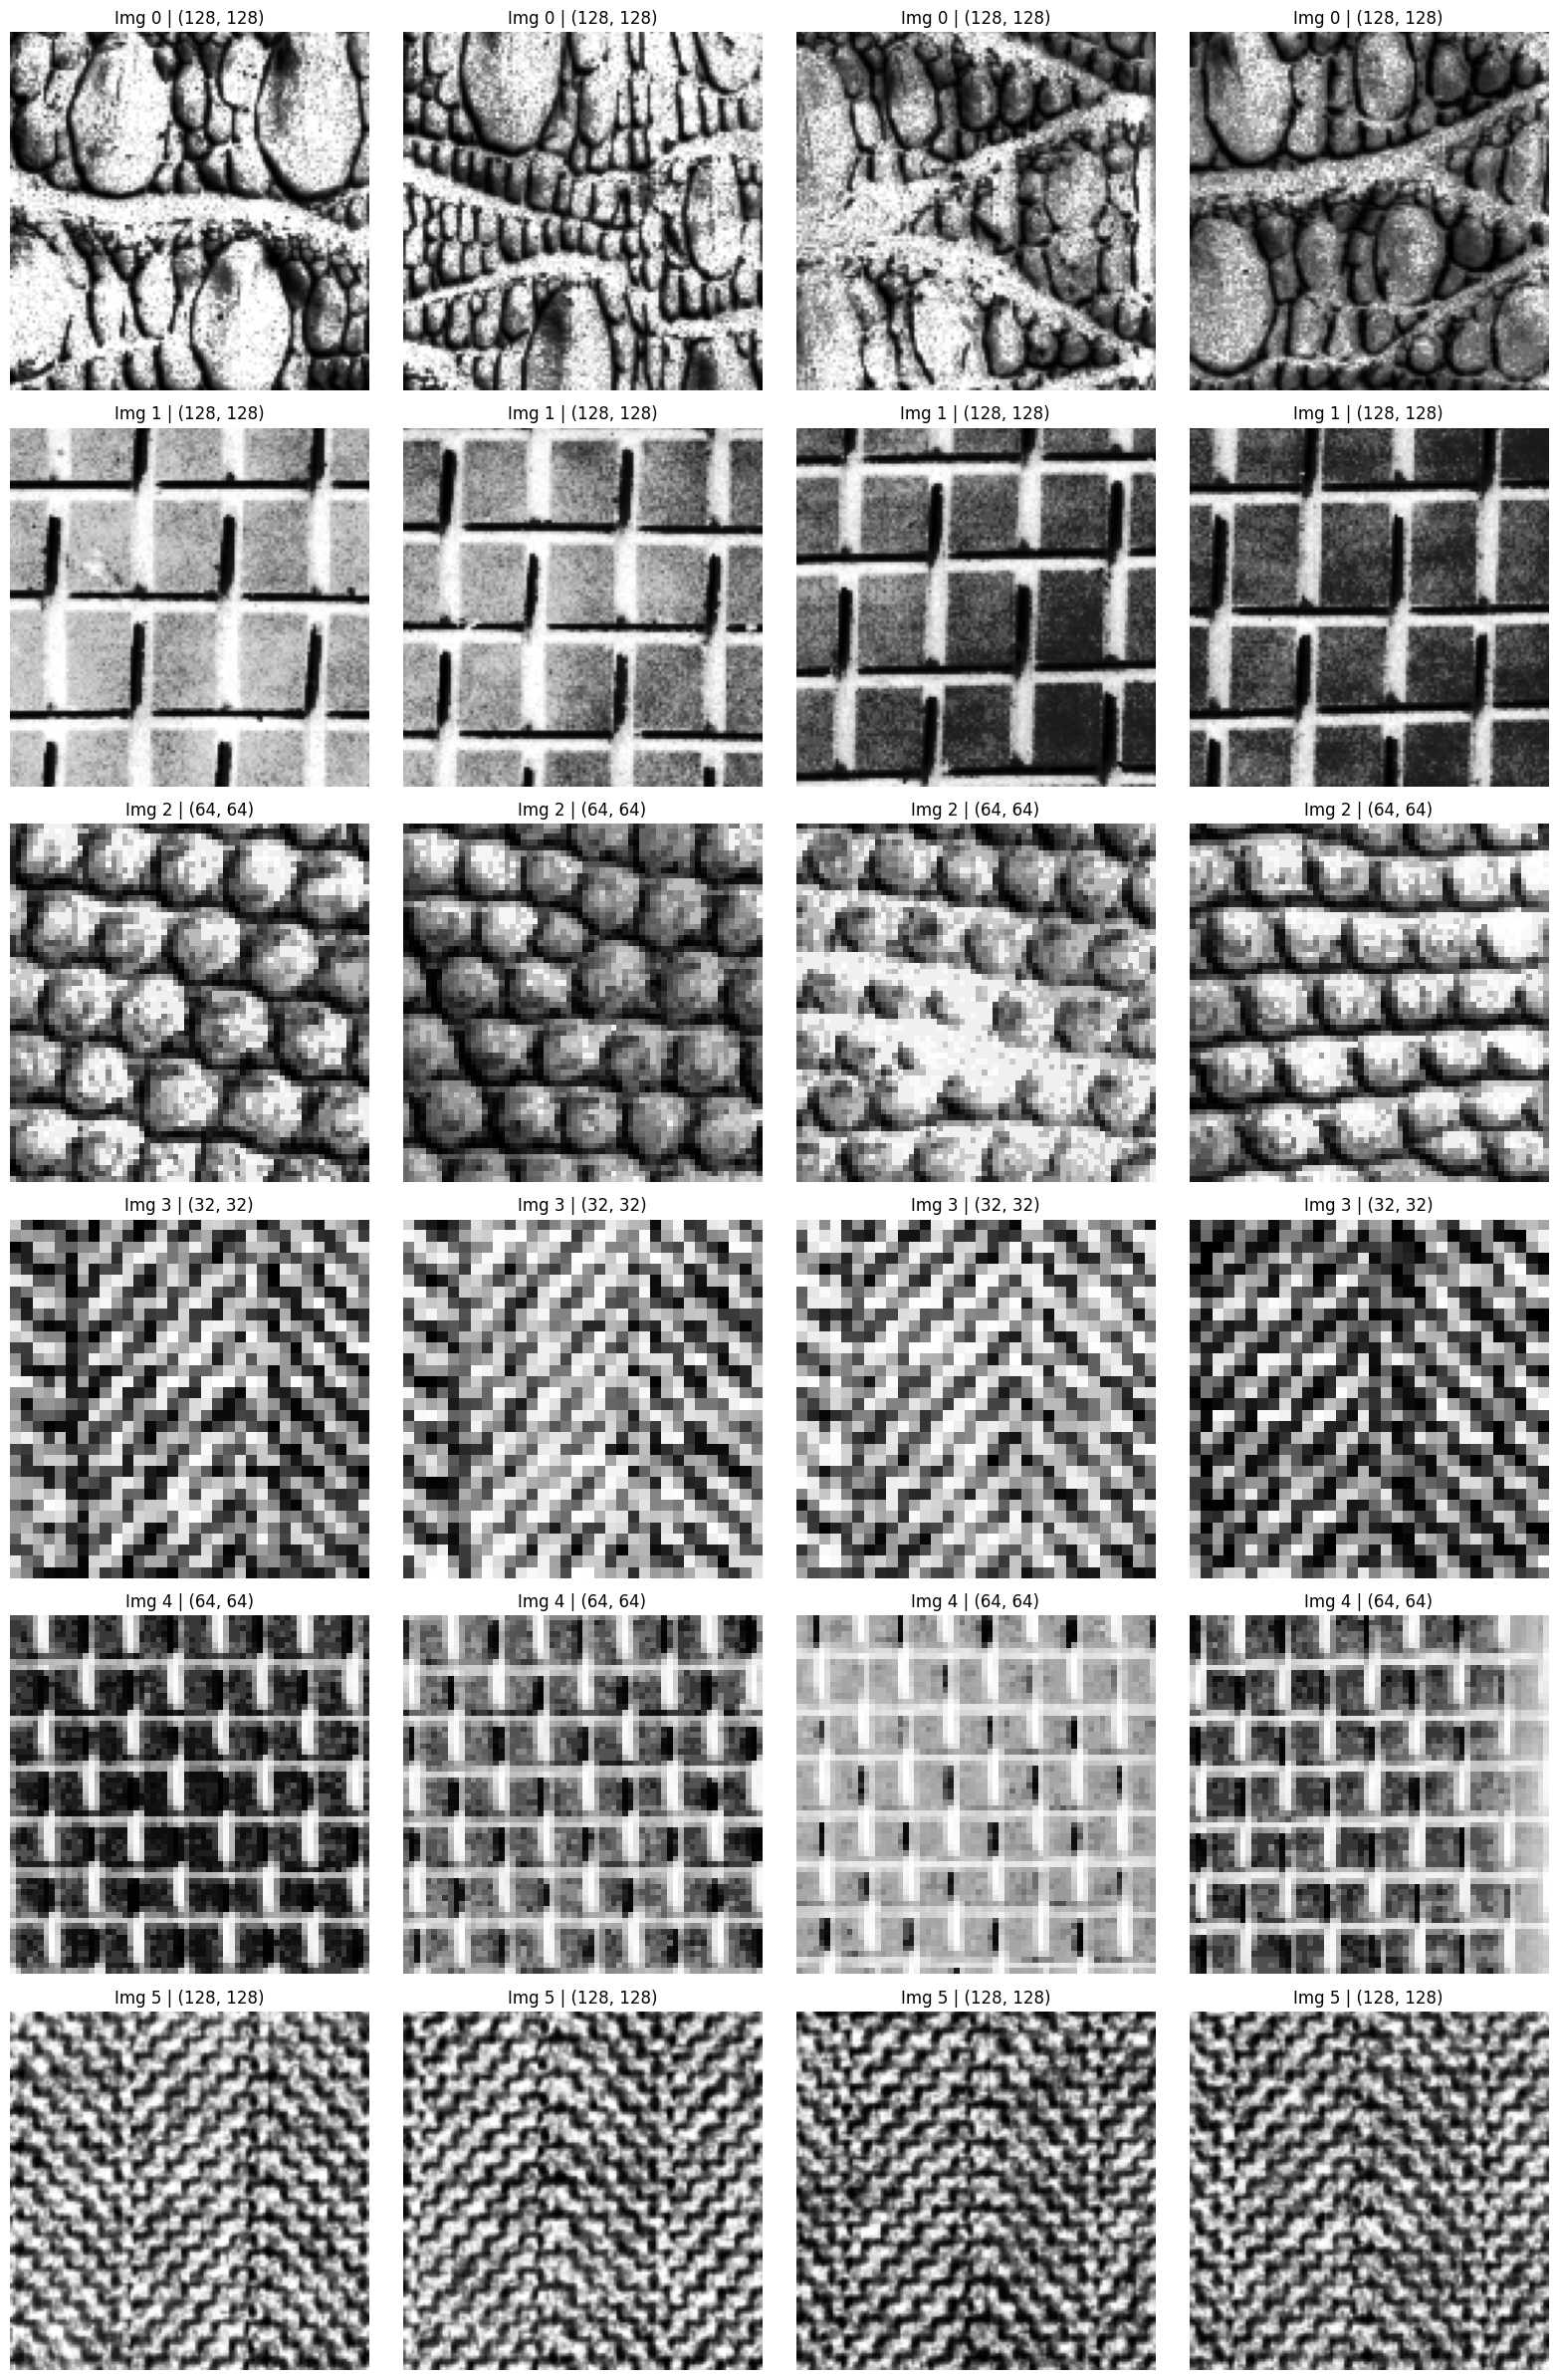

In [12]:
import matplotlib.pyplot as plt

# Número total de texeles en test
num_texeles = len(X_test)

# Configura la figura: por ejemplo, 4 columnas
columnas = 4
filas = (num_texeles + columnas - 1) // columnas

fig, axes = plt.subplots(filas, columnas, figsize=(4 * columnas, 4 * filas))

# Asegúrate de trabajar con una grilla 2D
axes = axes.flatten()

for i, (ax, texel, etiqueta) in enumerate(zip(axes, X_test, y_test)):
    ax.imshow(texel, cmap='gray')
    ax.set_title(f"Img {etiqueta[0]} | {etiqueta[1]}")
    ax.axis('off')

# Oculta los ejes sobrantes (si hay)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [13]:
X_train_features = [feature_extraction(texel) for texel in X_train]
X_test_features  = [feature_extraction(texel) for texel in X_test]


In [32]:
from itertools import combinations

def generar_combinaciones_propiedades(props):
    combinaciones = []
    for r in range(1, len(props) + 1):
        combinaciones.extend(combinations(props, r))
    return combinaciones


In [ ]:
def extract_glcm_combo(texel, props_combo, distances, angles):
    texel_uint8 = (texel * 255).astype(np.uint8) if texel.max() <= 1 else texel.astype(np.uint8)
    glcm = graycomatrix(texel_uint8, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    
    features = []
    for prop in props_combo:
        values = graycoprops(glcm, prop)
        features.extend(values.flatten())  
    return features


In [34]:
def evaluar_combinaciones_por_imagen(equalized_images, tamaños_por_imagen, props, distances, angles):
    combinaciones = generar_combinaciones_propiedades(props)
    resultados = []

    for idx, (img, tam_texel) in enumerate(zip(equalized_images, tamaños_por_imagen)):
        from skimage.util import view_as_windows
        if img.ndim == 3:
            from skimage.color import rgb2gray
            img = rgb2gray(img)

        texeles = view_as_windows(img, tam_texel, step=tam_texel[0])
        texeles = texeles.reshape(-1, *tam_texel)

        if len(texeles) < 5:
            print(f"⚠️ Imagen {idx} no tiene suficientes texeles")
            continue

        import random
        random.seed(42)
        seleccionados = random.sample(list(texeles), 4)
        resto = [v for v in texeles if not any(np.array_equal(v, s) for s in seleccionados)]

        for props_combo in combinaciones:
            X_train = [extract_glcm_combo(t, props_combo, distances, angles) for t in resto]
            y_train = [idx] * len(resto)

            X_test = [extract_glcm_combo(t, props_combo, distances, angles) for t in seleccionados]
            y_test = [idx] * len(seleccionados)

            clf = Pipeline([
                ('scaler', StandardScaler()),
                ('model', KNeighborsClassifier(n_neighbors=3))  # Puedes cambiar a SVM
            ])
            clf.fit(X_train, y_train)
            preds = clf.predict(X_test)
            acc = accuracy_score(y_test, preds)

            resultados.append({
                'imagen': idx,
                'tamaño_texel': tam_texel,
                'propiedades': props_combo,
                'num_propiedades': len(props_combo),
                'accuracy': acc
            })

    return resultados


In [ ]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


resultados_combos = evaluar_combinaciones_por_imagen(
    equalized_images,
    tamaños_por_imagen,
    props=['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation'],
    distances=[1, 2, 4],
    angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]
)


In [ ]:
import pandas as pd

df = pd.DataFrame(resultados_combos)
mejores_por_imagen = df.loc[df.groupby('imagen')['accuracy'].idxmax()]
print(mejores_por_imagen[['imagen', 'tamaño_texel', 'propiedades', 'accuracy']])


     imagen tamaño_texel  propiedades  accuracy
0         0   (128, 128)  (contrast,)       1.0
63        1   (128, 128)  (contrast,)       1.0
126       2     (64, 64)  (contrast,)       1.0
189       3     (32, 32)  (contrast,)       1.0
252       4     (64, 64)  (contrast,)       1.0
315       5   (128, 128)  (contrast,)       1.0


In [14]:
y_train = [etiqueta[0] for etiqueta in y_train]
y_test = [etiqueta[0] for etiqueta in y_test]


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

# Clasificador KNN
knn_model = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=3))
])

knn_model.fit(X_train_features, y_train)
knn_preds = knn_model.predict(X_test_features)
acc_knn = accuracy_score(y_test, knn_preds)
print("🔹 KNN Accuracy:", acc_knn)
print(classification_report(y_test, knn_preds))

🔹 KNN Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         4

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



In [16]:
# Clasificador SVM
svm_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(C=1.0, kernel='rbf'))
])

svm_model.fit(X_train_features, y_train)
svm_preds = svm_model.predict(X_test_features)
acc_svm = accuracy_score(y_test, svm_preds)
print("🔸 SVM Accuracy:", acc_svm)
print(classification_report(y_test, svm_preds))

🔸 SVM Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         4
           3       1.00      1.00      1.00         4
           4       1.00      1.00      1.00         4
           5       1.00      1.00      1.00         4

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



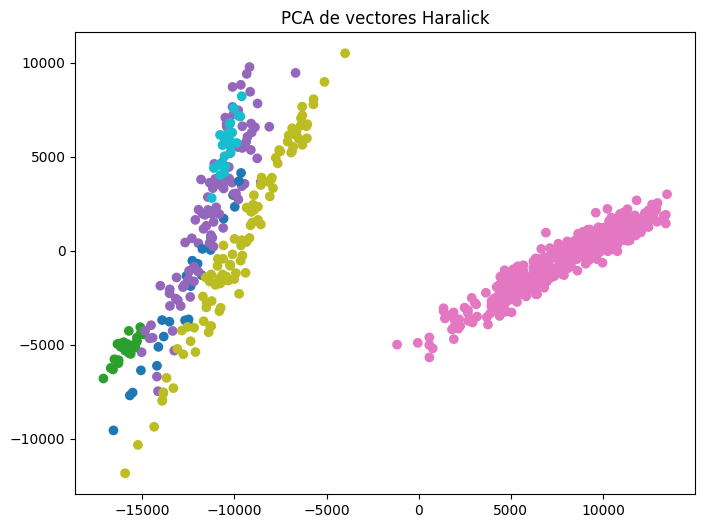

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X_all = X_train_features + X_test_features
y_all = y_train + y_test

X_reduced = PCA(n_components=2).fit_transform(X_all)

plt.figure(figsize=(8, 6))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y_all, cmap='tab10')
plt.title("PCA de vectores Haralick")
plt.show()
